# Weight Space Approximation with Random Fourier Features

r"""
This notebook demonstrates how to approximate an exact Gaussian process regression model (GPR) with random Fourier features in weight space. The end result is Figure 1 from from Wilson et al. "Efficiently sampling functions from Gaussian process posteriors" <cite data-cite="wilson2020efficiently"/>. This figure demonstrates that approximating an exact GPR model in weight space becomes increasingly more difficult as the training data grows. While the approximation remains accurate in areas within the training data and far away from the training data, predictions close to the training data points (but outside the training data interval) become less reliable. Note that Wilson et al. provide a method to alleviate exactly this problem; however, this is outside the scope of this notebook, where the emphasis is on how to build a weight space approximated Gaussian process model with random Fourier features in `gpflux`.

The basic idea is to approximate a stationary kernel $k(X,X^\prime)$ for one-dimensional inputs $X \in \mathbb{R}$ and $X^\prime \in \mathbb{R}$ according to Bochner's theorem:

$$
k(X, X^\prime) \approx \sum_{i=1}^I \phi_i(X) \phi_i(X^\prime),
$$
with $I$ Fourier features $\phi_i$  following Rahimi and Recht "Random features for large-scale kernel machines" (NeurIPS, 2007) defined as

$$
\phi_i(X) = \sqrt{\frac{2 \sigma^2}{l}} \cos(\theta_i X + \tau_i),
$$
where $\sigma^2$ refers to the kernel variance and $l$ to the kernel lengthscale. $\theta_i$ and $\tau_i$ are randomly drawn hyperparameters that determine each feature function $\phi_i$. The hyperparameter $\theta_i$ is randomly drawn from the kernel's spectral density. The spectral density of a stationary kernel is obtained by interpreting the kernel as a function of one argument only (i.e. the distance between $X$ and $X^\prime$) and performing a Fourier transform on that function, resulting in an unnormalised probability density (from which samples can be obtained). The hyperparameter $\tau_i$ is obtained by sampling from a uniform distribution $\tau_i \sim \mathcal{U}(0,2\pi)$. Note that both $\theta_i$ and $\tau_i$ are fixed and not optimised over. An interesting direction of future research is how to automatically identify those (but this is outside the scope of this notebook). If we drew infinitely many samples, i.e. $I \rightarrow \infty$, we would recover the true kernel perfectly.

The kernel approximation specified above enables you to express a supervised inference problem with training data $\mathcal{D} = \{(X_n,y_n)\}_{n=1,...,N}$ in weight space view as

$$
p(\textbf{w} | \mathcal{D}) = \frac{\prod_{n=1}^N p(y_n| \textbf{w}^\intercal \boldsymbol{\phi}(X_n), \sigma_\epsilon^2) p(\textbf{w})}{p(\mathcal{D})},
$$
where we assume $p(\textbf{w})$ to be a standard normal multivariate prior and $p(y_n| \textbf{w}^\intercal \boldsymbol{\phi}(X_n), \sigma_\epsilon^2)$ to be a univariate Gaussian observation model of the i.i.d. likelihood with mean $\textbf{w}^\intercal \boldsymbol{\phi}(X_n)$ and noise variance $\sigma_\epsilon^2$. The boldface notation $\boldsymbol{\phi}(X_n)$ refers to the vector-valued feature function that evaluates all features from $1$ up to $I$ for one particular input $X_n$. Under these assumptions, the posterior $p(\textbf{w} | \mathcal{D})$ enjoys a closed form and is Gaussian. Predictions can readily be obtained by sampling $\textbf{w}$ and evaluating the function sample $\textbf{w}$ at new locations $\{X_{n^\star}^\star\}_{n^\star=1,...,N^\star}$ as $\{\textbf{w}^\intercal \boldsymbol{\phi}(X_{n^\star}^\star)\}_{n^\star=1,...,N^\star}$.

The advantage of expressing a Gaussian process in weight space is that functions are represented as weight vectors $\textbf{w}$ (rather than actual functions $f(\cdot)$) from which samples can be obtained a priori without knowing where the function should be evaluated. When expressing a Gaussian process in function space view the latter is not possible, i.e. a function $f(\cdot)$ cannot be sampled without knowing where to evaluate the function, namely at $\{X_{n^\star}^\star\}_{n^\star=1,...,N^\star}$. Weight space approximated Gaussian processes therefore hold the potential to sample efficiently from Gaussian process posteriors, which is desirable in vanilla supervised learning but also in domains such as Bayesian optimisation or model-based reinforcement learning.

In the following example, we compare a weight space approximated GPR model (WSA model) with both a proper GPR model and a sparse variational Gaussian Process model (SVGP). GPR models and SVGP models are implemented in `gpflow`, but the two necessary ingredients for building the WSA model are part of `gpflux`: these are random Fourier feature functions via the `RandomFourierFeatures` class, and approximate kernels based on Bochner's theorem (or any other theorem that approximates a kernel with a finite number of feature functions, e.g. Mercer) via the `KernelWithFeatureDecomposition` class.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 7)
plt.rc("text")
plt.rcParams.update({"font.size": 20})
import tensorflow as tf

import gpflow as gpf
from gpflow.config import default_float
from gpflow.models import GPR, SVGP
from gpflow.kernels import RBF, Matern52
from gpflow.likelihoods import Gaussian
from gpflow.inducing_variables import InducingPoints

from gpflux.layers.basis_functions.random_fourier_features import RandomFourierFeatures
from gpflux.sampling.kernel_with_feature_decomposition import KernelWithFeatureDecomposition

Our aim is to demonstrate the decrease in predictive quality of a WSA model when increasing the number of training points. To that end, we perform two sets of experiments: one with few and one with many training data points. Each experiment compares a WSA model to an exact GPR and to an approximate SVGP model, resulting in six plots all in all.

We first define settings that remain the same across the two sets of experiments, like the interval of the training points, aspects of the generative model (i.e. kernel variance and lengthscale, and the variance of the observation model), and the number of feature functions of the WSA model.

The only aspect that is different across both experimental settings is the number of training data points. We increase the number of inducing points for the SVGP model to cope with this.

In [2]:
# experiment parameters that are the same for both sets of experiments
X_interval = [0.14, 0.5]  # interval where training points live
lengthscale = 0.1  # lengthscale for the kernel (which is not learned in all experiments, the kernel variance is 1)
number_of_basis_functions = 2000  # number of basis functions for weight-space approximated kernels
noise_variance = 1e-3  # noise variance of the likelihood (which is not learned in all experiments)
number_of_test_samples = 1024  # number of evaluation points for prediction
number_of_function_samples = (
    20  # number of function samples to be drawn from (approximate) posteriors
)

# experiment parameters that differ across both sets of experiments
number_of_train_samples = [4, 1000]  # number of training points
number_of_inducing_points = [4, 8]  # number of inducing points for SVGP models

# kernel class
kernel_class = Matern52  # set alternatively kernel_class = RBF

# plotting configuration
x_lim = [0.0, 1.0]
y_lim = [-3.5, 3.5]

We proceed by generating the training data for both experimental settings from a ground truth function which is a sample from a prior zero-mean GP with a predefined kernel (in our case, we use a `Matern52` kernel but we could have chosen an `RBF` kernel -- both of which are defined in `gpflow`).

In [3]:
# generate training data and evaluation points for both sets of experiments
kernel = kernel_class(lengthscales=lengthscale)  # kernel object to draw training dataset from
X, y, X_star = [], [], []  # training points, training observations, and test points for evaluation

# 1st iteration: experiments with few training points -- 2nd iteration: experiments with many training points
for i in range(len(number_of_train_samples)):

    # training points
    X.append(np.linspace(start=X_interval[0], stop=X_interval[1], num=number_of_train_samples[i]))

    # training observations generated from a zero-mean GP corrupted with Gaussian noise
    kXX = kernel.K(X[i][..., None])
    kXX_plus_noise_var = kXX + tf.eye(tf.shape(kXX)[0], dtype=kXX.dtype) * noise_variance
    lXX = tf.linalg.cholesky(kXX_plus_noise_var)
    y.append(
        tf.matmul(lXX, tf.random.normal([number_of_train_samples[i], 1], dtype=X[i].dtype))[..., 0]
    )

    # test points for evaluation
    X_star.append(np.linspace(start=x_lim[0], stop=x_lim[1], num=number_of_test_samples))

The `for` loop below iterates through both experimental settings with few and many training examples respectively. In each iteration, the GPR model is built first (and its prediction is used as "ground truth" to compare with the remaining models) followed by the SVGP model (which requires optimisation to identify internal parameters) and the WSA model.

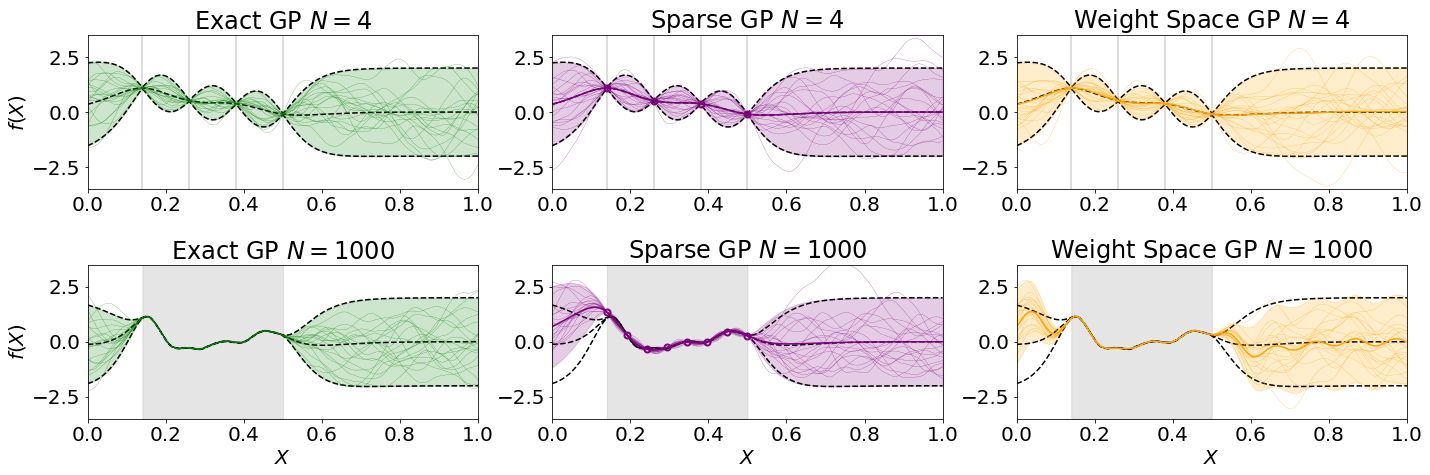

In [4]:
# create subplot frame
# 1st row: experiments with few training examples, 2nd row: experiments with many training examples
# 1st col: exact Gaussian process regression (GPR), 2nd col: sparse variational Gaussian process model (SVGP),
# 3rd col: weight space approximation (WSA) of the exact GPR posterior with random Fourier features
fig, axs = plt.subplots(2, 3)


# 1st iteration: experiments with few training points -- 2nd iteration: experiments with many training points
for experiment in range(len(number_of_train_samples)):

    # subplot titles and axis labels
    axs[experiment, 0].set_title("Exact GP $N=" + str(number_of_train_samples[experiment]) + "$")
    axs[experiment, 1].set_title("Sparse GP $N=" + str(number_of_train_samples[experiment]) + "$")
    axs[experiment, 2].set_title(
        "Weight Space GP $N=" + str(number_of_train_samples[experiment]) + "$"
    )
    axs[experiment, 0].set_ylabel("$f(X)$")
    if experiment == 1:
        axs[experiment, 0].set_xlabel("$X$")
        axs[experiment, 1].set_xlabel("$X$")
        axs[experiment, 2].set_xlabel("$X$")

    # plot training point locations X and set axis limits
    for i in range(3):  # iterate through all three subplots (GPR, SVGP and WSA)
        if (
            experiment == 0
        ):  # as vertical lines for the first set of experiments with few training samples
            axs[experiment, i].vlines(
                X[experiment], ymin=y_lim[0], ymax=y_lim[1], colors="lightgrey"
            )
        else:  # as fill plots for the second set of experiments with many training samples
            axs[experiment, i].fill_between(
                X[experiment], y_lim[0], y_lim[1], color="gray", alpha=0.2
            )
        axs[experiment, i].set_xlim(x_lim)
        axs[experiment, i].set_ylim(y_lim)

    # create the GPR "ground truth" model
    gpr_model = GPR(
        data=(X[experiment][..., None], y[experiment][..., None]),
        kernel=kernel_class(lengthscales=lengthscale),
        noise_variance=noise_variance,
    )

    # predict function mean and variance, and draw function samples (without observation noise)
    f_mean, f_var = gpr_model.predict_f(X_star[experiment][..., None])
    f_samples = gpr_model.predict_f_samples(
        X_star[experiment][..., None], num_samples=number_of_function_samples
    )
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # plot mean and std lines from the GPR model as "ground truth" in all three plots
    for i in range(3):
        axs[experiment, i].plot(X_star[experiment], f_mean[..., 0], linestyle="--", color="black")
        axs[experiment, i].plot(
            X_star[experiment], f_mean_minus_2std[..., 0], linestyle="--", color="black"
        )
        axs[experiment, i].plot(
            X_star[experiment], f_mean_plus_2std[..., 0], linestyle="--", color="black"
        )

    # visualise GPR model predictions (mean +/- 2 * std and function samples) in the first column
    axs[experiment, 0].fill_between(
        X_star[experiment],
        f_mean_minus_2std[..., 0],
        f_mean_plus_2std[..., 0],
        color="green",
        alpha=0.2,
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 0].plot(
            X_star[experiment], f_samples[i, ..., 0], color="green", linewidth=0.2
        )

    # create the SVGP model
    if (
        experiment == 0
    ):  # inducing points equal the training data for the first experiment with few training points
        Z = X[experiment].copy()[..., None]
    else:  # inducing points are randomly chosen for the second experiment with many training points
        Z = np.linspace(X_interval[0], X_interval[1], number_of_inducing_points[experiment])[
            ..., None
        ]
    svgp_model = SVGP(
        kernel=kernel_class(lengthscales=lengthscale),
        likelihood=Gaussian(variance=noise_variance),
        inducing_variable=InducingPoints(Z=Z),
    )
    gpf.set_trainable(
        svgp_model.kernel, False
    )  # the training data has been sampled from a known kernel!
    gpf.set_trainable(svgp_model.likelihood, False)  # the likelihood variance is known!
    gpf.set_trainable(svgp_model.inducing_variable, False)  # inducing point locations are fixed!

    def optimize_model_with_scipy(model):
        optimizer = gpf.optimizers.Scipy()
        optimizer.minimize(
            model.training_loss_closure((X[experiment][..., None], y[experiment][..., None])),
            variables=model.trainable_variables,
            method="l-bfgs-b",
            options={"disp": False, "maxiter": 10000},
        )

    optimize_model_with_scipy(svgp_model)

    # predict function mean and variance, and draw function samples (without observation noise)
    f_mean, f_var = svgp_model.predict_f(X_star[experiment][..., None])
    f_samples = svgp_model.predict_f_samples(
        X_star[experiment][..., None], num_samples=number_of_function_samples
    )
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # visualise SVGP model predictions (mean +/- 2 * std and function samples) in the second column
    axs[experiment, 1].fill_between(
        X_star[experiment],
        f_mean_minus_2std[..., 0],
        f_mean_plus_2std[..., 0],
        color="purple",
        alpha=0.2,
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 1].plot(
            X_star[experiment], f_samples[i, ..., 0], color="purple", linewidth=0.2
        )
    axs[experiment, 1].plot(X_star[experiment], f_mean[..., 0], color="purple")

    # visualise predictions at inducing point locations (without observation noise)
    Z = svgp_model.inducing_variable.Z
    q_mu, _ = svgp_model.predict_f(Z)
    axs[experiment, 1].plot(
        Z[..., 0], q_mu[..., 0], "o", mfc="none", markeredgewidth=2, color="purple"
    )

    # create exact GPR model with weight-space approximated kernel (WSA model)
    feature_functions = RandomFourierFeatures(
        kernel=kernel_class(lengthscales=lengthscale),
        output_dim=number_of_basis_functions,
        dtype=default_float(),
    )
    feature_coefficients = np.ones((number_of_basis_functions, 1), dtype=default_float())
    kernel = KernelWithFeatureDecomposition(
        kernel=None, feature_functions=feature_functions, feature_coefficients=feature_coefficients
    )
    gpr_model = GPR(
        data=(X[experiment][..., None], y[experiment][..., None]),
        kernel=kernel,
        noise_variance=noise_variance,
    )

    # predict function mean and variance, and draw function samples (without observation noise)
    f_mean, f_var = gpr_model.predict_f(X_star[experiment][..., None])
    f_samples = gpr_model.predict_f_samples(
        X_star[experiment][..., None], num_samples=number_of_function_samples
    )
    f_mean_plus_2std = f_mean + 2 * f_var ** 0.5
    f_mean_minus_2std = f_mean - 2 * f_var ** 0.5

    # visualise WSA model predictions (mean +/- 2 * std and function samples) in the third column
    axs[experiment, 2].fill_between(
        X_star[experiment],
        f_mean_minus_2std[..., 0],
        f_mean_plus_2std[..., 0],
        color="orange",
        alpha=0.2,
    )
    for i in range(f_samples.shape[0]):
        axs[experiment, 2].plot(
            X_star[experiment], f_samples[i, ..., 0], color="orange", linewidth=0.2
        )
    axs[experiment, 2].plot(X_star[experiment], f_mean[..., 0], color="orange")


# show the plot
fig.tight_layout()
plt.show()

The results are visualised in a 2 $\times$ 3 plot with 6 subplots. The first row refers to experiments with few training data points and the second row to experiments with many training data points. The first column depicts the exact GPR model in green, the second column the SVGP model in purple and the third column the WSA model in orange. In each plot, training data points are marked in grey (as vertical bars in the first row and fill plots in the second row). We also assume the GPR model's prediction as ground truth, which is therefore plotted in all plots as black dashed lines (indicating mean +/- 2 * std).

In each plot, the model's prediction in terms of mean +/- 2 * std is plotted through fill plots, and function samples from the (approximate) posterior through thin solid lines (thick solid lines depict mean functions in the second and third column). Note that the coloured purple circles in the second column refer to predictions at the inducing point locations of the SVGP model.

It can be seen that, as training data points increase from the first to the second row, the predictions of the WSA model decrease drastically in areas relevant to extrapolation (i.e. close to but not inside the training data interval) because a lot of Fourier features would be required to accurately approximate a function sample drawn from a Matern kernel (because of its non-smooth nature). The same effect would be less severe for a function sample drawn from an RBF kernel that is smoother than a Matern kernel (and can hence be reliably approximated with fewer Fourier features). Note that the experiment is stochastic because the ground truth function sample from the prior kernel is random. There might be outcomes of the experiment in which the explained effect is less prominent than in other random outcomes -- so the last code block might require execution more than once to obtain a clear result.